## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""

reduce_lr_factor = [0.2, 0.5, 0.8]
redice_lr_patient = [3, 5]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                                  min_lr=1e-12, 
                                  monitor='val_loss', 
                                  patience=reduce_patient, 
                                  verbose=1)
    
    model.fit(x_train, 
              y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

W0724 01:21:54.574608 16580 deprecation_wrapper.py:119] From C:\Users\user\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0724 01:21:54.575607 16580 deprecation_wrapper.py:119] From C:\Users\user\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0724 01:21:54.577609 16580 deprecation_wrapper.py:119] From C:\Users\user\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0724 01:21:54.667578 16580 deprecation_wrapper.py:119] From C:\Users\user\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.



Numbers of exp: 0, reduce_factor: 0.20, reduce_patient: 3


W0724 01:21:54.897507 16580 deprecation_wrapper.py:119] From C:\Users\user\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0724 01:21:54.907503 16580 deprecation_wrapper.py:119] From C:\Users\user\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0724 01:21:55.005471 16580 deprecation.py:323] From C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
__________

50000/50000 [==============================] - 2s 36us/step - loss: 1.2501 - acc: 0.5657 - val_loss: 1.4886 - val_acc: 0.4801
Epoch 15/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.2303 - acc: 0.5726 - val_loss: 1.4674 - val_acc: 0.4831
Epoch 16/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.2108 - acc: 0.5803 - val_loss: 1.4571 - val_acc: 0.4902
Epoch 17/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.1920 - acc: 0.5884 - val_loss: 1.4654 - val_acc: 0.4842
Epoch 18/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.1730 - acc: 0.5940 - val_loss: 1.4485 - val_acc: 0.4921
Epoch 19/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.1564 - acc: 0.6009 - val_loss: 1.4531 - val_acc: 0.4904
Epoch 20/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.1383 - acc: 0.6080 - val_loss: 1.4483 - val_acc: 0.4920
Epoch 21/25
50000/50000 [=====================

50000/50000 [==============================] - 3s 55us/step - loss: 2.3463 - acc: 0.2396 - val_loss: 2.0928 - val_acc: 0.2989
Epoch 2/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.8771 - acc: 0.3521 - val_loss: 1.9314 - val_acc: 0.3461
Epoch 3/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.7402 - acc: 0.3929 - val_loss: 1.7912 - val_acc: 0.3822
Epoch 4/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.6642 - acc: 0.4182 - val_loss: 1.7450 - val_acc: 0.3952
Epoch 5/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.6127 - acc: 0.4360 - val_loss: 1.6900 - val_acc: 0.4145
Epoch 6/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.5719 - acc: 0.4496 - val_loss: 1.6668 - val_acc: 0.4208
Epoch 7/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.5362 - acc: 0.4620 - val_loss: 1.6432 - val_acc: 0.4278
Epoch 8/25
50000/50000 [============================

50000/50000 [==============================] - 2s 36us/step - loss: 1.2358 - acc: 0.5731 - val_loss: 1.4833 - val_acc: 0.4790
Epoch 25/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.2235 - acc: 0.5777 - val_loss: 1.4770 - val_acc: 0.4815
Numbers of exp: 5, reduce_factor: 0.80, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_16 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalizatio

50000/50000 [==============================] - 2s 38us/step - loss: 0.8621 - acc: 0.7079 - val_loss: 1.3497 - val_acc: 0.5322
Epoch 12/25
50000/50000 [==============================] - 2s 38us/step - loss: 0.8417 - acc: 0.7151 - val_loss: 1.3403 - val_acc: 0.5311

Epoch 00012: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
Epoch 13/25
50000/50000 [==============================] - 2s 38us/step - loss: 0.8024 - acc: 0.7315 - val_loss: 1.3032 - val_acc: 0.5463
Epoch 14/25
50000/50000 [==============================] - 2s 38us/step - loss: 0.7922 - acc: 0.7353 - val_loss: 1.3036 - val_acc: 0.5461
Epoch 15/25
50000/50000 [==============================] - 2s 39us/step - loss: 0.7871 - acc: 0.7389 - val_loss: 1.3019 - val_acc: 0.5464
Epoch 16/25
50000/50000 [==============================] - 2s 39us/step - loss: 0.7814 - acc: 0.7395 - val_loss: 1.3056 - val_acc: 0.5508
Epoch 17/25
50000/50000 [==============================] - 2s 39us/step - loss: 0.7757 - acc: 0.7415 -

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 4s 71us/step - loss: 2.9910 - acc: 0.1018 - val_loss: 2.8882 - val_acc: 0.1216
Epoch 2/25
50000/50000 [==============================] - 2s 38us/step - loss: 2.8536 - acc: 0.1192 - val_loss: 2.8055 - val_acc: 0.1408
Epoch 3/25
50000/50000 [==============================] - 2s 38us/step - loss: 2.7729 - acc: 0.1340 - val_loss: 2.7472 - val_acc: 0.1554
Epoch 4/25
50000/50000 [==============================] - 2s 38us/step - loss: 2.7148 - acc: 0.1464 - val_loss: 2.6987 - val_acc: 0.1620
Epoch 5/25
50000/50000 [==============================] - 2s 38us/step - loss: 2.6691 - acc: 0.1550 - val_loss: 2.6583 - val_acc: 0.1688
Epoch 6/25
50000/50000 [==============================] - 2s 38us/step - loss: 2.6314 - acc: 0.1631 - val_loss: 2.6229 - val_acc: 0.1727
Epoch 7/25
50000/50000 [==============================] - 2s 38us/step - loss: 2.5991 - acc: 0.1703 - val_loss: 2.5909 - val_acc

50000/50000 [==============================] - 2s 38us/step - loss: 2.3340 - acc: 0.2357 - val_loss: 2.3517 - val_acc: 0.2350
Epoch 25/25
50000/50000 [==============================] - 2s 38us/step - loss: 2.3244 - acc: 0.2386 - val_loss: 2.3423 - val_acc: 0.2372
Numbers of exp: 10, reduce_factor: 0.80, reduce_patient: 3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_31 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalizati

Epoch 12/25
50000/50000 [==============================] - 2s 37us/step - loss: 2.4486 - acc: 0.2143 - val_loss: 2.4378 - val_acc: 0.2160
Epoch 13/25
50000/50000 [==============================] - 2s 37us/step - loss: 2.4318 - acc: 0.2188 - val_loss: 2.4236 - val_acc: 0.2191
Epoch 14/25
50000/50000 [==============================] - 2s 39us/step - loss: 2.4170 - acc: 0.2223 - val_loss: 2.4100 - val_acc: 0.2216
Epoch 15/25
50000/50000 [==============================] - 2s 38us/step - loss: 2.4033 - acc: 0.2238 - val_loss: 2.3979 - val_acc: 0.2230
Epoch 16/25
50000/50000 [==============================] - 2s 37us/step - loss: 2.3913 - acc: 0.2277 - val_loss: 2.3866 - val_acc: 0.2256
Epoch 17/25
50000/50000 [==============================] - 2s 38us/step - loss: 2.3779 - acc: 0.2305 - val_loss: 2.3754 - val_acc: 0.2290
Epoch 18/25
50000/50000 [==============================] - 2s 38us/step - loss: 2.3667 - acc: 0.2327 - val_loss: 2.3656 - val_acc: 0.2319
Epoch 19/25
50000/50000 [=========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 4s 83us/step - loss: 3.0199 - acc: 0.1062 - val_loss: 2.9366 - val_acc: 0.1152
Epoch 2/25
50000/50000 [==============================] - 2s 39us/step - loss: 2.8725 - acc: 0.1246 - val_loss: 2.8215 - val_acc: 0.1406
Epoch 3/25
50000/50000 [==============================] - 2s 38us/step - loss: 2.7583 - acc: 0.1451 - val_loss: 2.7333 - val_acc: 0.1574
Epoch 4/25
50000/50000 [==============================] - 2s 38us/step - loss: 2.6638 - acc: 0.1650 - val_loss: 2.6568 - val_acc: 0.1707
Epoch 5/25
50000/50000 [==============================] - 2s 38us/step - loss: 2.5853 - acc: 0.1807 - val_loss: 2.5909 - val_acc: 0.1871
Epoch 6/25
50000/50000 [==============================] - 2s 37us/step - loss: 2.5186 - acc: 0.1963 - val_loss: 2.5325 - val_acc: 0.1988
Epoch 7/25
50000/50000 [==============================] - 2s 38us/step - loss: 2.4616 - acc: 0.2083 - val_loss: 2.4776 - val_acc

50000/50000 [==============================] - 2s 37us/step - loss: 1.9881 - acc: 0.3166 - val_loss: 2.0258 - val_acc: 0.3094
Epoch 25/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.9761 - acc: 0.3202 - val_loss: 2.0153 - val_acc: 0.3135
Numbers of exp: 15, reduce_factor: 0.50, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_46 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalizati

Epoch 12/25
50000/50000 [==============================] - 2s 37us/step - loss: 2.2242 - acc: 0.2531 - val_loss: 2.2259 - val_acc: 0.2604
Epoch 13/25
50000/50000 [==============================] - 2s 37us/step - loss: 2.1953 - acc: 0.2609 - val_loss: 2.1988 - val_acc: 0.2672
Epoch 14/25
50000/50000 [==============================] - 2s 37us/step - loss: 2.1682 - acc: 0.2678 - val_loss: 2.1743 - val_acc: 0.2726
Epoch 15/25
50000/50000 [==============================] - 2s 37us/step - loss: 2.1442 - acc: 0.2757 - val_loss: 2.1516 - val_acc: 0.2773
Epoch 16/25
50000/50000 [==============================] - 2s 37us/step - loss: 2.1201 - acc: 0.2820 - val_loss: 2.1299 - val_acc: 0.2809
Epoch 17/25
50000/50000 [==============================] - 2s 37us/step - loss: 2.1003 - acc: 0.2876 - val_loss: 2.1110 - val_acc: 0.2864
Epoch 18/25
50000/50000 [==============================] - 2s 37us/step - loss: 2.0800 - acc: 0.2932 - val_loss: 2.0924 - val_acc: 0.2895
Epoch 19/25
50000/50000 [=========

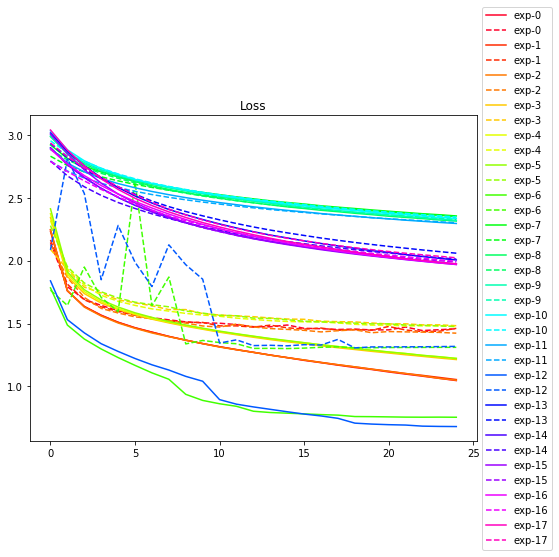

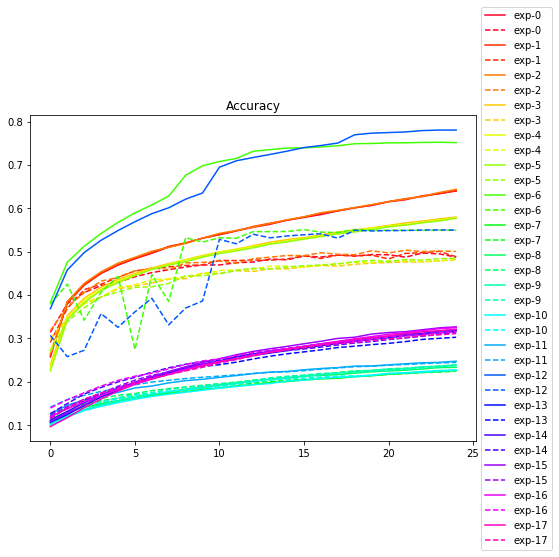

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])), results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])), results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])), results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])), results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()